In [159]:
import os
import pickle as pkl
import pandas as pd

In [160]:
result_columns = ['imp', 'dataset', 'metric', 'value',
                  'num_samples', 'num_features', 'uncorr_frac', 'seed']
results_df = None
results_dir = 'clique_results'

def parse_pickle(fname, n, p, uncorr_frac, seed):
    results = []
    with open(fname, 'rb') as f:
        r_map = pkl.load(f)
    for k, v in r_map.items():
        imp, ds, metric = k.split('_')
        results.append([imp, ds, metric, v[0], n, p, uncorr_frac, seed])
    return pd.DataFrame(results, columns=result_columns)
    
# read results from output directory
for fname in os.listdir(results_dir):
    if os.path.isdir(fname): continue
    if 'cv_results' not in fname: continue
    f_sp = os.path.splitext(fname)[0].split('_')
    n = int(f_sp[2].replace('n', ''))
    p = int(f_sp[3].replace('p', ''))
    uncorr_frac = float(f_sp[4].replace('u', ''))
    seed = int(f_sp[5].replace('s', ''))
    df = parse_pickle(os.path.join(results_dir, fname),
                      n, p, uncorr_frac, seed)
    if results_df is None:
        results_df = df
    else:
        results_df = pd.concat((results_df, df))
    
results_df.head(n=10)

,imp,dataset,metric,value,num_samples,num_features,uncorr_frac,seed
0,torch,train,auroc,0.965556,500,10,0.0,2
1,torch,train,aupr,0.971458,500,10,0.0,2
2,torch,train,acc,0.895000,500,10,0.0,2
3,torch,test,auroc,0.942529,500,10,0.0,2
4,torch,test,aupr,0.931840,500,10,0.0,2
5,torch,test,acc,0.880000,500,10,0.0,2
6,r,train,auroc,0.960305,500,10,0.0,2
7,r,train,aupr,0.967166,500,10,0.0,2
8,r,train,acc,0.880000,500,10,0.0,2
9,r,test,auroc,0.929803,500,10,0.0,2


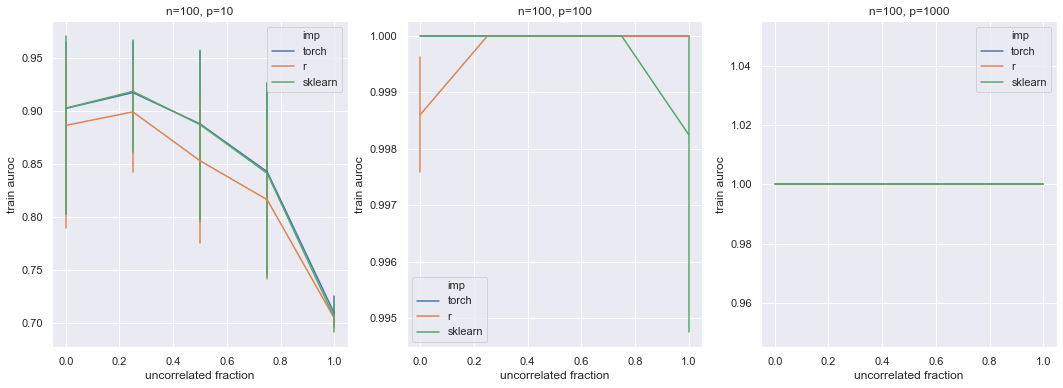

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
# fig, axarr = plt.subplots(3, 3)
fig, axarr = plt.subplots(1, 3)
fig.set_figwidth(18)
# fig.set_figheight(18)
fig.set_figheight(6)

metric = 'auroc'
# for i, num_samples in enumerate((100, 500, 1000)):
for i, num_samples in enumerate([100]):
    for j, num_feats in enumerate((10, 100, 1000)):
        # ax = axarr[i, j]
        ax = axarr[j]
        filter_df = results_df[(results_df['num_samples'] == num_samples) &
                               (results_df['num_features'] == num_feats) &
                               (results_df['dataset'] == 'train') &
                               (results_df['metric'] == metric)]
        sns.lineplot(data=filter_df, x='uncorr_frac', y='value',
                     hue='imp', err_style='bars', ax=ax)
        ax.set_title('n={}, p={}'.format(num_samples, num_feats))
        ax.set_xlabel('uncorrelated fraction')
        ax.set_ylabel('train {}'.format(metric))
    

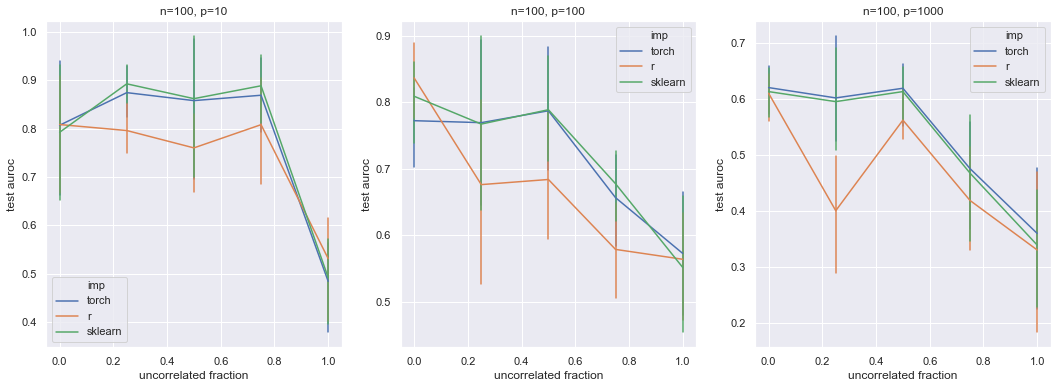

In [162]:
sns.set()
#fig, axarr = plt.subplots(3, 3)
fig, axarr = plt.subplots(1, 3)
fig.set_figwidth(18)
# fig.set_figheight(18)
fig.set_figheight(6)

metric = 'auroc'
# for i, num_samples in enumerate((100, 500, 1000)):
for i, num_samples in enumerate([100]):
    for j, num_feats in enumerate((10, 100, 1000)):
        # ax = axarr[i, j]
        ax = axarr[j]
        filter_df = results_df[(results_df['num_samples'] == num_samples) &
                               (results_df['num_features'] == num_feats) &
                               (results_df['dataset'] == 'test') &
                               (results_df['metric'] == metric)]
        sns.lineplot(data=filter_df, x='uncorr_frac', y='value',
                     hue='imp', err_style='bars', ax=ax)
        ax.set_title('n={}, p={}'.format(num_samples, num_feats))
        ax.set_xlabel('uncorrelated fraction')
        ax.set_ylabel('test {}'.format(metric))

In [163]:
result_columns = ['imp', 'metric', 'value', 'num_samples', 
                  'num_features', 'uncorr_frac', 'seed']
results_df = None
results_dir = 'clique_results'

def compile_coefs(results_dir, n, p, uncorr_frac, seed):
    true_coefs = []
    coefs_map = {}
    suffix = 'n{}_p{}_u{}_s{}.txt'.format(n, p, uncorr_frac, seed)
    network_file = os.path.join(
        'sim_networks',
        'sim_groups_p{}_u{}_s{}.tsv'.format(p, uncorr_frac, seed)
    )
    for fname in os.listdir(results_dir):
        if ('coefs' not in fname) or (suffix not in fname): continue
        imp = fname.split('_')[0]
        coefs = np.loadtxt(os.path.join(results_dir, fname), delimiter='\t',
                           ndmin=1)
        if imp == 'true':
            true_coefs = coefs
        else:
            coefs_map[imp] = coefs
    # assert true_coefs != [], '{}'.format(suffix)
    return calculate_metrics(network_file, true_coefs, coefs_map)

def calculate_metrics(network_file, true_coefs, coefs_map):
    import networkx as nx
    results = []
    # intercept is at the beginning of the list
    G = nx.read_weighted_edgelist(network_file, delimiter='\t')
    for imp, coefs in coefs_map.items():
        l2_loss = calculate_l2_loss(G, coefs)
        l1_loss = calculate_l1_loss(G, coefs)
        true_loss = calculate_true_loss(coefs, true_coefs)
        results.append([imp, 'l2_loss', l2_loss, n, p, uncorr_frac, seed])
        results.append([imp, 'l1_loss', l1_loss, n, p, uncorr_frac, seed])
        results.append([imp, 'true_loss', true_loss, n, p, uncorr_frac, seed])
    return pd.DataFrame(results, columns=result_columns)

def calculate_l2_loss(G, coefs):
    import networkx as nx
    L = nx.laplacian_matrix(G).toarray()
    assert coefs.shape[0]-1 == L.shape[0]
    return coefs[1:].T @ (L @ coefs[1:])

def calculate_l1_loss(G, coefs):
    return sum([abs(coefs[int(i)] - coefs[int(j)]) for (i, j) in G.edges if i != j])

def calculate_true_loss(coefs, true_coefs):
    # truncate in case where some of the coefs are uncorrelated with outcome
    t_coefs = coefs[:true_coefs.shape[0]]
    return sum([abs(t_coefs[i] - true_coefs[i]) for i in range(t_coefs.shape[0])])

# read results from output directory
for fname in os.listdir(results_dir):
    if os.path.isdir(fname): continue
    if 'true_coefs' not in fname: continue
    f_sp = os.path.splitext(fname)[0].split('_')
    n = int(f_sp[2].replace('n', ''))
    p = int(f_sp[3].replace('p', ''))
    uncorr_frac = float(f_sp[4].replace('u', ''))
    seed = int(f_sp[5].replace('s', ''))
    df = compile_coefs(results_dir, n, p, uncorr_frac, seed)
    if results_df is None:
        results_df = df
    else:
        results_df = pd.concat((results_df, df))
    
results_df.head(n=10)

,imp,metric,value,num_samples,num_features,uncorr_frac,seed
0,sklearn,l2_loss,131.669608,100,100,0.0,2
1,sklearn,l1_loss,447.358400,100,100,0.0,2
2,sklearn,true_loss,58.243320,100,100,0.0,2
3,torch,l2_loss,377.327221,100,100,0.0,2
4,torch,l1_loss,760.244100,100,100,0.0,2
5,torch,true_loss,55.875830,100,100,0.0,2
6,r,l2_loss,30.058022,100,100,0.0,2
7,r,l1_loss,213.865153,100,100,0.0,2
8,r,true_loss,58.645648,100,100,0.0,2
0,r,l2_loss,12.044828,100,100,0.5,0


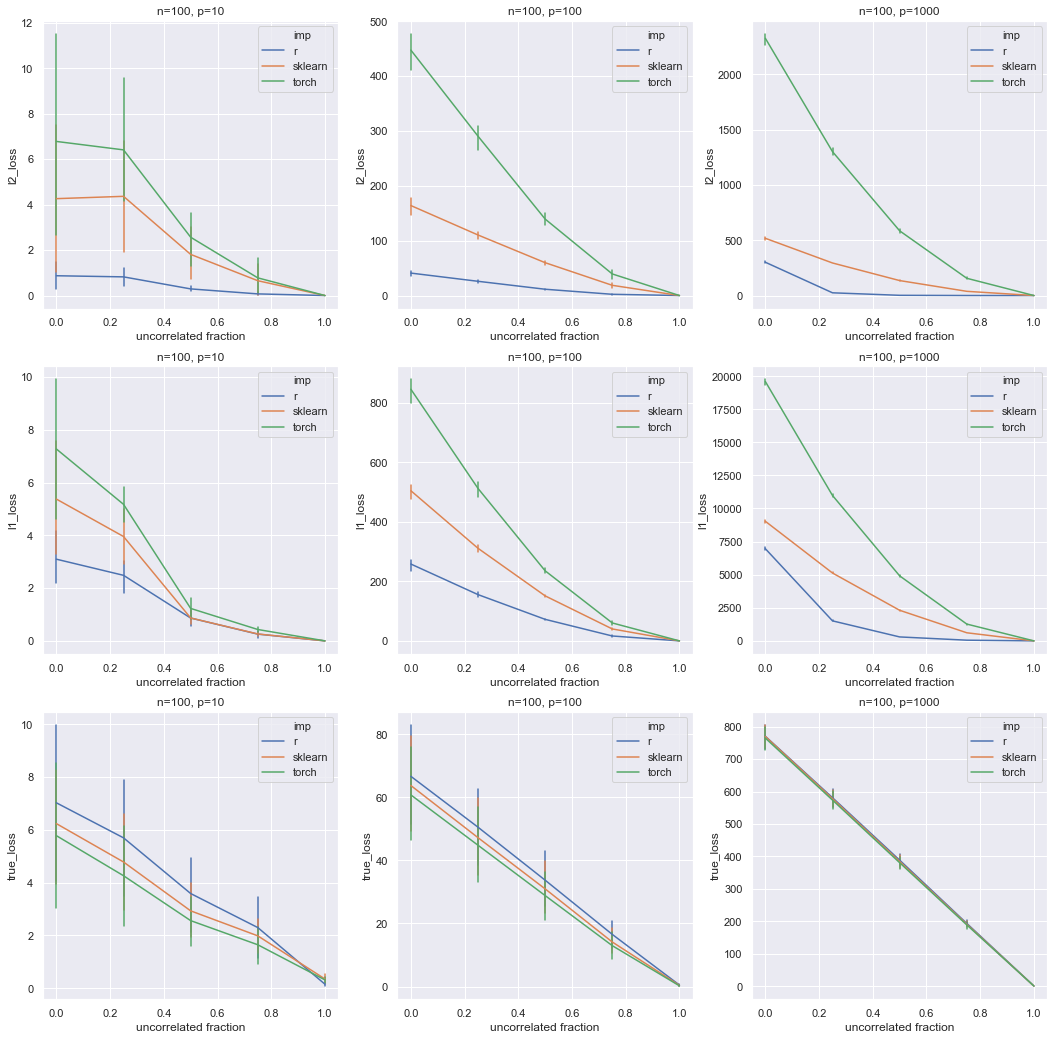

In [164]:
sns.set()
fig, axarr = plt.subplots(3, 3)
fig.set_figwidth(18)
fig.set_figheight(18)

num_samples = 100
for i, metric in enumerate(('l2_loss', 'l1_loss', 'true_loss')):
    for j, num_feats in enumerate((10, 100, 1000)):
        ax = axarr[i, j]
        filter_df = results_df[(results_df['num_samples'] == num_samples) &
                               (results_df['num_features'] == num_feats) &
                               (results_df['metric'] == metric)]
        filter_df = filter_df.sort_values(by='imp')
        sns.lineplot(data=filter_df, x='uncorr_frac', y='value',
                     hue='imp', err_style='bars', ax=ax)
        ax.set_title('n={}, p={}'.format(num_samples, num_feats))
        ax.set_xlabel('uncorrelated fraction')
        ax.set_ylabel('{}'.format(metric))
    